In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import copy
import os
import platform
%matplotlib inline

In [178]:
class KMeans:
    
    def __init__(self,dictionary):
        self.X_train = list()
        self.y_train = list() 
        self.X_test  = list()
        self.y_test  = list()
        self.X_train_x = list()
        self.y_train_x = list()
        self.num_folds = dictionary['num_folds'] 
        self.k_choices = dictionary['k_choices']
        self.data_dir = dictionary['data_dir']
        self.kc = 10  #Default value of the clusters
        self.max_iter = 100
        self.lpi = []

    def load_pickle(self, f):
        version = platform.python_version_tuple()
        if version[0] == '2':
            return  pickle.load(f)
        elif version[0] == '3':
            return  pickle.load(f, encoding='latin1')
        raise ValueError("invalid python version: {}".format(version))

    def load_CIFAR_batch(self, filename):
        with open(filename, 'rb') as f:
            datadict = self.load_pickle(f)
            X = datadict['data']
            Y = datadict['labels']
            X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
            Y = np.array(Y)
            return X, Y

    def load_CIFAR10(self, PATH):
        xs = []
        ys = []
        for t in range(1,6):
            f = os.path.join(PATH, 'data_batch_%d' % (t, ))
            X, Y = self.load_CIFAR_batch(f)
            xs.append(X)
            ys.append(Y)    
        Xtr = np.concatenate(xs)
        Ytr = np.concatenate(ys)
        del X, Y
        Xte, Yte = self.load_CIFAR_batch(os.path.join(PATH, 'test_batch'))
        return Xtr/255.0, Ytr, Xte/255.0, Yte
    
    def loadData(self):
        
        self.X_train, self.y_train, self.X_test, self.y_test = self.load_CIFAR10(self.data_dir)
        
        print('Shape of Training: ', self.X_train.shape)
        print('Shape of Training labels : ', self.y_train.shape)
        print('Shape of Test: ', self.X_test.shape)
        print('Shape of Test labels: ', self.y_test.shape)
        
    def visualize(self):
        classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        classes_total = len(classes)
        samples_per_class = 7
        for y, cls in enumerate(classes):
            idxs = np.flatnonzero(self.y_train == y)
            idxs = np.random.choice(idxs, samples_per_class, replace=False)
            for i, indx in enumerate(idxs):
                plt_indx = i * classes_total + y + 1
                plt.subplot(samples_per_class, classes_total, plt_indx)
                plt.imshow(self.X_train[indx])
                plt.axis('off')
                if i == 0:
                    plt.title(cls)
        plt.show()
    
    def clusterMeanInit(self):
        np.random.seed(np.random.randint(0,100000))
        self.means = []
        for i in range(self.kc):
            rand_index = np.random.choice(range(len(self.data)))
            self.means.append(self.data[rand_index])
    
    def clstrInit(self):
        self.cls = {'data':{i:[] for i in range(self.kc)}}
        self.cls['labels']={i:[] for i in range(self.kc)}

    def meanfiting(self,data,labels, kc):
        self.kc = kc
        self.data = np.copy(data)
        self.labels = np.copy(labels)
        self.pred_lbl = [None for _ in range(len(self.data))]
        self.clusterMeanInit()
        self.itr = 0
        old_means = [np.zeros(shape=(data.shape[1],)) for _ in range(self.kc)]
        while not self.converged(self.itr,old_means,self.means):
            old_means = copy.deepcopy(self.means)
            self.clstrInit()
            for j,s in (enumerate(self.data)):
                low_disp = float('inf')
                for i,cntr in enumerate(self.means):
                    displacement = np.linalg.norm(s-cntr)
                    if displacement<low_disp:
                        low_disp = displacement
                        self.pred_lbl[j] = i
                if self.pred_lbl[j] is not None:
                        self.cls['data'][self.pred_lbl[j]].append(s)                    
                        self.cls['labels'][self.pred_lbl[j]].append(self.labels[j])
            self.rdesign_clstr()
            self.meansUpdate()
            self.getError()
            self.itr+=1
        self.getPerformance()
        
    
    def meansUpdate(self):
        for i in range(self.kc):
            clstr = self.cls['data'][i]
            if len(clstr) == 0:
                self.means[i] = self.data[np.random.choice(range(len(self.data)))]
            else:
                self.means[i] = np.mean(np.vstack((self.means[i],clstr)),axis=0)
    
    def rdesign_clstr(self):
        for idx,m in list(self.cls['data'].items()):
            self.cls['data'][idx] = np.array(m)

    def converged(self,itr,centroids,updated_centroids):
        if itr > self.max_iter:
            return True
        self.centroids_dist = np.linalg.norm(np.array(updated_centroids)-np.array(centroids))
        if self.centroids_dist<=1e-10:
            return True
        return False

    def getError(self):
        self.error = 0
        for i,j in list(self.cls['data'].items()):
            if j is not None:
                for v in j:
                    self.error += np.linalg.norm(v-self.means[i])
        self.lpi.append(self.error)
    
    def getPerformance(self):
        self.clslbl = []
        self.clsif = []
        self.clsper = []
        for c,lbl in list(self.cls['labels'].items()):
            if isinstance(lbl[0],(np.ndarray)):
                lbl = [l[0] for l in labels]
            occur = 0
            ml = max(set(lbl), key=lbl.count)
            self.clslbl.append(ml)
            for l in lbl:
                if l == ml:
                    occur+=1
            acc = occur/len(list(lbl))
            self.clsif.append([ml,occur,len(list(lbl)),acc])
            self.clsper.append(acc)
            self.accuracy = sum(self.clsper)/self.kc
        self.lbls = []
        for i in range(len(self.pred_lbl)):
            self.lbls.append(self.clslbl[self.pred_lbl[i]])

        
    def cross_test(self, X, y):

        self.pred_lbl = [None for _ in range(X.shape[0])]
        for j,s in (enumerate(X)):
                low_disp = float('inf')
                for i,c in enumerate(self.means):
                    d = np.linalg.norm(s-c)
                    
                    if d<low_disp:
                        low_disp = d
                        self.pred_lbl[j] = self.clsif[i][0]
        
        acc = 0
        for i in range(len(y)):
            if y[i] == self.pred_lbl[i]:
                acc = acc + 1
        
        return acc/len(y)
    
    def test(self):
        
        num_test = 10
        mask = list(range(num_test))
        X_test = np.copy(self.X_test[mask])
        y_test = np.copy(self.y_test[mask])

        X_test = np.reshape(X_test, (X_test.shape[0], -1))
        
        self.pred_lbl = [None for _ in range(X_test.shape[0])]
        for j,s in (enumerate(X_test)):
                low_disp = float('inf')
                for i,c in enumerate(self.means):
                    d = np.linalg.norm(s-c)
                    
                    if d<low_disp:
                        low_disp = d
                        self.pred_lbl[j] = self.clsif[i][0]
        
        acc = 0
        for i in range(len(y_test)):
            if y_test[i] == self.pred_lbl[i]:
                acc = acc + 1
        total_test = len(y_test)
        calc_accuracy = float(acc) / num_test
        print('We found %d / %d correct => accuracy: %f' % (acc, total_test, calc_accuracy))
        
        
    def crossValidation(self):
        
        num_folds = self.num_folds
        k_choices = self.k_choices

        X_train_folds = []
        y_train_folds = []
        
        num_training = 50
        mask = list(range(num_training))
        X_train = np.copy(self.X_train[mask])
        y_train = np.copy(self.y_train[mask])

        num_test = 10
        mask = list(range(num_test))
        X_test = np.copy(self.X_test[mask])
        y_test = np.copy(self.y_test[mask])

        X_train = np.reshape(X_train, (X_train.shape[0], -1))
        X_test = np.reshape(X_test, (X_test.shape[0], -1))
#         print(X_train.shape, X_test.shape)
        

        X_train_folds = np.array_split(X_train,num_folds)
        y_train_folds = np.array_split(y_train,num_folds)
        k_to_accuracies = {}
        
        print("Printing our 5-fold accuracies for varying values of k:")
        print()
        
        for k in k_choices:
            k_to_accuracies[k] = []
            self.kc = k
            for num_knn in range(0,num_folds):
                X_test = X_train_folds[num_knn]
                y_test = y_train_folds[num_knn]
                X_train = X_train_folds
                y_train = y_train_folds

                temp = np.delete(X_train,num_knn,0)
                X_train = np.concatenate((temp),axis = 0)
                y_train = np.delete(y_train,num_knn,0)
                y_train = np.concatenate((y_train),axis = 0)

                self.meanfiting(X_train, y_train, k)

                accuracy = self.cross_test(X_test, y_test)
                
                k_to_accuracies[k].append(accuracy)
                print('k = %d, accuracy = %f' % (k, accuracy))


        print('+----------------------------------------------+')
        for k in sorted(k_to_accuracies):
            avg = 0
            for accuracy in k_to_accuracies[k]:
                print('k = %d, accuracy = %f' % (k, accuracy))
                avg = avg + accuracy
                
            print('k = %d, average accuracy =%f'% (k, avg / num_folds))
            print()


In [179]:
dictionary = {'num_folds' : 5,
             'k_choices' : [3, 5, 7, 11],
             'data_dir' : './data/cifar-10-batches-py'}

In [180]:
kmeans = KMeans(dictionary)

Shape of Training:  (50000, 32, 32, 3)
Shape of Training labels :  (50000,)
Shape of Test:  (10000, 32, 32, 3)
Shape of Test labels:  (10000,)


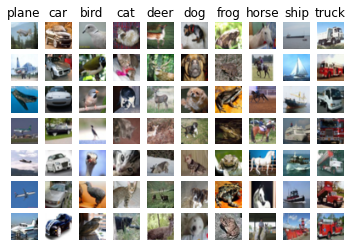

In [181]:
kmeans.loadData()
kmeans.visualize()

In [182]:
kmeans.crossValidation()

Printing our 5-fold accuracies for varying values of k:

k = 3, accuracy = 0.200000
k = 3, accuracy = 0.000000
k = 3, accuracy = 0.000000
k = 3, accuracy = 0.100000
k = 3, accuracy = 0.000000
k = 5, accuracy = 0.100000
k = 5, accuracy = 0.300000
k = 5, accuracy = 0.200000
k = 5, accuracy = 0.100000
k = 5, accuracy = 0.000000
k = 7, accuracy = 0.300000
k = 7, accuracy = 0.300000
k = 7, accuracy = 0.000000
k = 7, accuracy = 0.000000
k = 7, accuracy = 0.200000
k = 11, accuracy = 0.300000
k = 11, accuracy = 0.100000
k = 11, accuracy = 0.000000
k = 11, accuracy = 0.200000
k = 11, accuracy = 0.000000
+----------------------------------------------+
k = 3, accuracy = 0.200000
k = 3, accuracy = 0.000000
k = 3, accuracy = 0.000000
k = 3, accuracy = 0.100000
k = 3, accuracy = 0.000000
k = 3, average accuracy =0.060000

k = 5, accuracy = 0.100000
k = 5, accuracy = 0.300000
k = 5, accuracy = 0.200000
k = 5, accuracy = 0.100000
k = 5, accuracy = 0.000000
k = 5, average accuracy =0.140000

k = 7, ac

In [183]:
kmeans.test()

We found 1 / 10 correct => accuracy: 0.100000
